In [1]:
#%matplotlib notebook

In [5]:
import time
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from skimage.filters import gaussian

import math

from datetime import date

from glob import glob
from scipy import ndimage
from skimage import img_as_float, io
import imageio
import json

## Overview

This code is used to take a large image and then split it into individual components which will be processed separately (stardist), and then stitch them back together afterwards to form a processed version of the original. Ideally, the raw image file, the grid overlaid image, as well as the post-processed image will all be retained.

The steps to achieve this are as follows:

1. Input image


2. Image slicer
    - overlay a grid, with overlapping cells
    - create subimages based on cell coordinates
    - save subimages to a created folder on disk
    - save coordinates of subimages that will be serialized into a json file in the same folder
    
    
3. Process subimage tiles
    - stardist segmentation


4. Reconstruct processed version of original image
    - separate file from raw original


5. Output should be the original image, the subimage tiles, and the post-processed construct

Object segmentation through stardist is computationally expensive and has an upper limit on image file size, so by breaking the original into more manageable subimages, this should mitigate the issue.

## Code mechanics

We begin by pulling information about the dimensions of the image using `.shape`:

```
sample.shape
(21504, 19558)
```
Then set up our parameters:

```
tile_step = 2000
tile_size = 2048

```

- `tile_step` is the increment along the x and y axis which will determine the size of the overall grid

- `tile_size` is the size of individual grid cells
Note that the `tile_size` is larger than `tile_step` (2048 vs. 2000), thus causing overlaps from tile to tile. This is intentional to accomodate for objects that are split along gridlines. The overlaps serve as a buffer zone so that split objects can be stitched together later.

We calculate how many tiles will fit across the length and width of the image:

```
length = math.ceil(sample.shape[0]/tile_step)
width = math.ceil(sample.shape[1]/tile_step)
print(length)
print(width)

11
10
```

### Setting up the loop

```
tile_range_r = np.arange(0, sample.shape[0]+tile_size, tile_step)
tile_range_c = np.arange(0, sample.shape[1]+tile_size, tile_step)
```

- `tile_range` consists of values from 0 to the ceiling of `shape` values + `tile_size`, in increments of `tile_step`, effectively a list of row/column length. The addition of one increment of `tile_size` to the `shape` value ensures that the range fully covers the size of the image being processed. The overhang is negligible as it will not affect the creation of a grid.

---
Using our current values, our outputs are:
```
tile_range_r
[0, 2000, 4000, 8000, 10000, 12000, 14000, 16000, 18000, 20000, 22000]

tile_range_c
[0, 2000, 4000, 8000, 10000, 12000, 14000, 16000, 18000, 20000]
```

---

### Integrating meshgrid

```
xs, ys = np.meshgrid(tile_range_r, tile_range_c, indexing='ij')
```

`meshgrid` is a method where a cartesian grid is generated given certain parameters. In this case, our grid is composed of coordinates given by `tile_range_r` and `tile_range_c`. Indexing has been changed from cartesian to matrix indexing. This will set up the overlay that we need.

### Main `for` loop

```
for ii, tile in enumerate(rs.ravel()):
    
    r_min = rs.ravel()[ii]
    r_max = np.min([rs.ravel()[ii]+tile_size, sample.shape[0]])
    
    c_min = cs.ravel()[ii]
    c_max = np.min([cs.ravel()[ii]+tile_size, sample.shape[1]])
        
    sub_image = sample[r_min:r_max,c_min:c_max]
    img_coordinates.append([r_min, r_max, c_min, c_max])
```

we begin by defining variables to capture the edges of the subimage tiles. The `r_max` and `c_max` values are offset by 2048 pixels to introduce the overlap that takes into account edge objects, which will be stitched together post-processing. `sub_image` is defined as all values within the range of `r_min` to `r_max` and `c_min` to `c_max`. And the min/max values themselves are then added to an initialized list, which will keep track of each corner of each subimage tile generated.

---

```
    for i in range((length*width)):
        
        if ii == i:
            
            rect = Rectangle((c_min, r_min), c_max-c_min, r_max-r_min, linewidth=1, edgecolor='g', facecolor='none')
            ax.add_patch(rect)
            
            ax.text(c_min, r_min, str(r_min)+", "+str(c_min))
            
            plt.figure()
            plt.imshow(sub_image)
            
            img_pos['_DAPI_Overview_subimage_'+str(i).zfill(5)] = [int(j) for j in img_coordinates[i]]
```


## Issues

- There is currently an indexing issue with the for loop, as the y-axis is being clipped prematurely. I suspect that this is because of step sizes and rounding issues when assigning values to the tile_range variable.
    - The maximum values for each listed range is the nearest multiple of 2000 below the actual value.
    - Indexing issue has been mitigated by adding the `tile_size` to the `shape` value when calculating x and y ranges


- indexing issue with filename generation
    - fixed by replacing `elif` statements with the `zfill` method

- issue with capturing edge coordinates up to true shape values
    - fixed by changing indexing mode in meshgrid from cartesian to matrix
    
- image slicing of the `for` loop is incomplete
    - some images are not properly displayed, which could mean that the subimage generation is not properly executing
    - it may be an issue with the nested portion of the `for` loop
    - fixed by double-checking the index references for consistency throughout the script, and the nested portion of the `for` loop has been altered slightly (removed `else` statement)

In [6]:
#if on laptop
sample = img_as_float(io.imread('C:/Users/jv92c/Documents/mFISH/sample_data/DAPI_Overview_cropped.tif'))

In [ ]:
#if at office machine
sample = img_as_float(io.imread('C:/Users/john.villanueva/Documents/sample_data/DAPI_Overview.tif'))

In [7]:
today = date.today()
sample.shape

(11248, 5856)

In [5]:
if not os.path.exists('C:/Users/jv92c/Documents/mFISH/sample_data/DAPI_Overview_subimg'):
    os.makedirs('C:/Users/jv92c/Documents/mFISH/sample_data/DAPI_Overview_subimg')

In [8]:
#slice intervals
tile_step = 2000

#size of the 2D slice
#also determines the overlap between FOVs for use in stitching of edge objects
tile_size = 2048

In [9]:
length = math.ceil(sample.shape[0]/tile_step)
width = math.ceil(sample.shape[1]/tile_step)

In [10]:
#range in the x-direction determined by width of image; row length
tile_range_r = np.arange(0, sample.shape[0], tile_step)

#range in the y-direction determined by height; column height
tile_range_c = np.arange(0, sample.shape[1], tile_step)

rs, cs = np.meshgrid(tile_range_r, tile_range_c, indexing='ij')

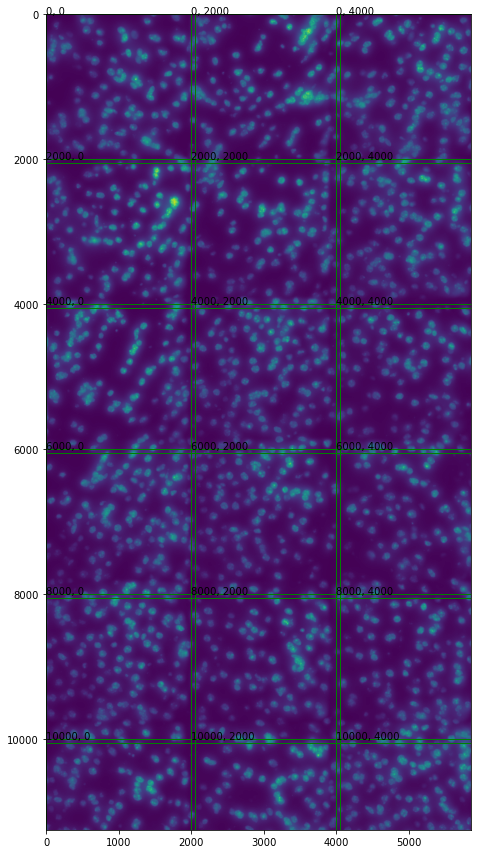

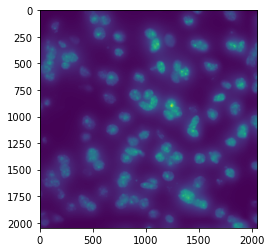

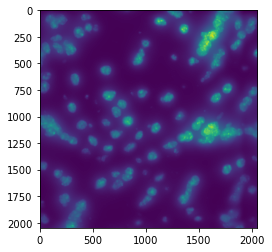

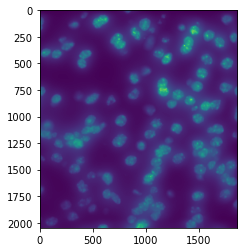

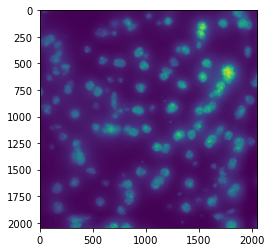

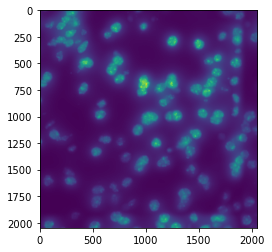

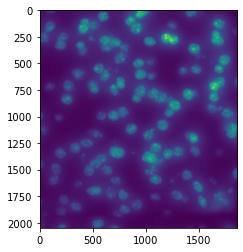

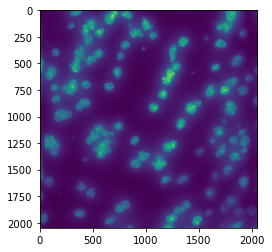

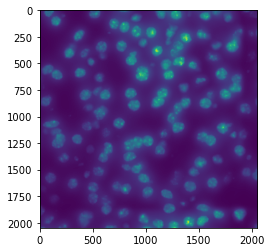

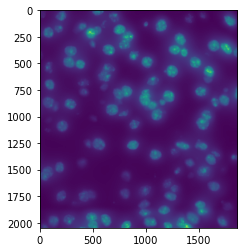

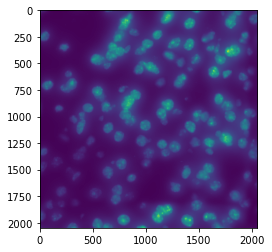

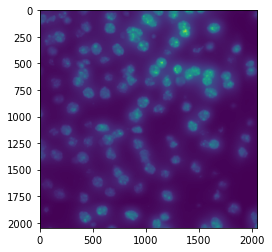

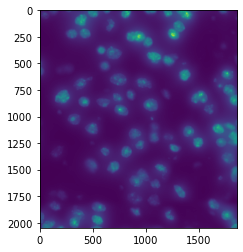

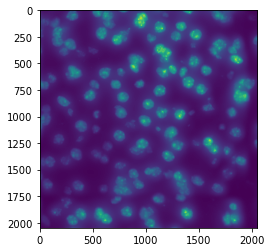

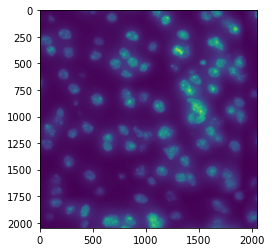

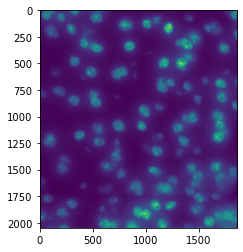

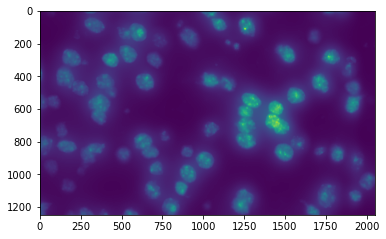

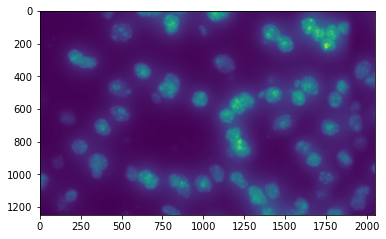

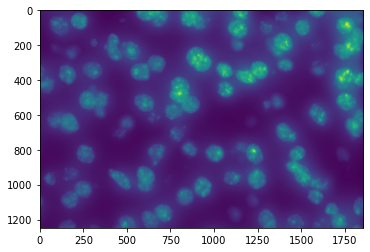

In [11]:
plt.figure(figsize= [15,15])
plt.imshow(sample)
ax = plt.gca()

img_coordinates = []
img_pos = {}

for ii, tile in enumerate(rs.ravel()):
    
    #setting the coordinates
    r_min = rs.ravel()[ii]
    r_max = np.min([rs.ravel()[ii]+tile_size, sample.shape[0]])
    
    c_min = cs.ravel()[ii]
    c_max = np.min([cs.ravel()[ii]+tile_size, sample.shape[1]])
        
    sub_image = sample[r_min:r_max,c_min:c_max]
    img_coordinates.append([r_min, r_max, c_min, c_max])
    
    for i in range((length*width)):
        
        if ii == i:
            
            #grid overlay for sample image
            rect = Rectangle((c_min, r_min), c_max-c_min, r_max-r_min, linewidth=1, edgecolor='g', facecolor='none')
            ax.add_patch(rect)
            
            #upper-left corner coordinates of each tile
            ax.text(c_min, r_min, str(r_min)+", "+str(c_min))
            
            # figure to display subimage
            plt.figure()
            plt.imshow(sub_image)
            
            #creating a dictionary for export to json
            img_pos['_DAPI_Overview_subimage_'+str(i).zfill(5)] = [int(j) for j in img_coordinates[i]]
            #add this string <today.strftime("%Y%m%d")+> in front of _DAPI_Overview_subimage if you want to have a timestamp as part of the file handle

#### Context manager

"w" is a variable, which is the output of the file that is being opened. This variable only exists within the context
of this code block

if the statement is done/fails, the file will still close.
```
# with open(<filename>, 'w') as w:
# json.dump(my_dictionary, w)
```

no need to set up classes, just proper serialization of the json file

In [16]:
#today.strftime("%Y%m%d") for the date
#+str(int(time.time())) for the timestamp

filename = '_DAPI_Overview_subimage_'

In [18]:
#use path to access directory of images
#assuming that they'll be in the same folder post-stardist

with open(filename, 'w') as file:    
    json.dump(img_pos, file)

In [19]:
with open(filename) as file:    
    coordinates = json.load(file)

#### Reconstructing the image

The goal is to read `tif` files stored to disk and by using the coordinates stored in a `json` file, to change values of a zero `ndarray` to that of the subimage tile being read.

First is to read just the raw tiles, then to move on to reading post-processed tiles.

In [52]:
#creating a zero array to begin image reconstruction

boundary = []

for key in coordinates:
    boundary.append(coordinates[key])
    
canvas = np.zeros((boundary[-1][1], boundary[-1][3]))
canvas

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])